# Square Bells Sweep Analysis

This notebook gives a compact, publication-style workflow for square-bells sweep outputs.

Conventions used throughout:
- We analyze fields as `field[x_index, y_index]`.
- Fixed-`y` strip profiles along `x` use `field[:, y_index]`.


In [56]:
from pathlib import Path

import h5py
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Matplotlib styling (Seaborn is used only for colormaps)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman", "Times New Roman", "DejaVu Serif"],
    "font.size": 13,
    "axes.titlesize": 14,
    "axes.labelsize": 13,
    "legend.fontsize": 11,
})

# Sweep selection
P_SCATTER = 1.0
SWEEP_TIMESTAMP = None  # e.g. "2026-02-08_010941"; None -> latest for this p

# Single-run selection by indexed parameter-grid coordinates
I_IDX = 0
J_IDX = 0


In [57]:
def find_sweep_data_dir(p_scatter: float, timestamp: str | None = None) -> Path:
    """Locate a repo-local sweep data directory from downloaded results."""
    bases = [Path("results"), Path("projects/square_bells_ucsb/results")]
    roots = [b for b in bases if b.exists()]
    if not roots:
        raise FileNotFoundError("Could not find `results/` or `projects/square_bells_ucsb/results/`.")

    tag = f"square_bells_ucsb_sweep_p={float(p_scatter):.1f}_"
    candidates = []
    for root in roots:
        candidates.extend([p for p in root.glob(f"{tag}*") if p.is_dir()])

    if not candidates:
        available = []
        for root in roots:
            available.extend(sorted([p.name for p in root.glob("square_bells_ucsb_sweep_*")]))
        raise FileNotFoundError(
            f"No sweeps found for p={p_scatter}. Available" + "\n" + "\n".join(available)
        )

    if timestamp is not None:
        candidates = [p for p in candidates if timestamp in p.name]
        if not candidates:
            raise FileNotFoundError(f"No sweep matched timestamp={timestamp!r} for p={p_scatter}.")

    sweep_dir = sorted(candidates)[-1]
    data_dir = sweep_dir / "data"
    if not data_dir.exists():
        raise FileNotFoundError(f"Found sweep but missing data/: {sweep_dir}")
    return data_dir


def parse_params_from_filename(filename: str) -> dict:
    stem = filename[:-3] if filename.endswith(".h5") else filename
    keys = ["bias", "gamma_mc", "gamma_mr", "p_scatter", "index_global"]
    params = {}
    for key in keys:
        marker = f"{key}="
        if marker not in stem:
            continue
        tail = stem.split(marker, 1)[1]
        value = tail.split("_", 1)[0]
        try:
            params[key] = float(value)
        except ValueError:
            params[key] = value
    return params


def scan_runs(root: Path):
    return [(parse_params_from_filename(path.name), path) for path in sorted(root.glob("*.h5"))]


def build_index(runs, x_key="gamma_mr", y_key="gamma_mc"):
    x_vals = sorted({p[x_key] for p, _ in runs if x_key in p})
    y_vals = sorted({p[y_key] for p, _ in runs if y_key in p})
    x_to_i = {v: i for i, v in enumerate(x_vals)}
    y_to_j = {v: j for j, v in enumerate(y_vals)}
    by_ij = {}
    for params, path in runs:
        if x_key in params and y_key in params:
            by_ij[(x_to_i[params[x_key]], y_to_j[params[y_key]])] = (params, path)
    return x_vals, y_vals, by_ij


def load_observables(path: Path):
    """Load one run and transpose fields once so downstream code uses [x, y]."""
    with h5py.File(path, "r") as f:
        return {
            "a0": f["a0"][:].T,
            "a1": f["a1"][:].T,
            "b1": f["b1"][:].T,
            "x": f["x"][:],
            "y": f["y"][:],
            "meta": dict(f.attrs),
        }


In [58]:
ROOT_DIR = find_sweep_data_dir(P_SCATTER, SWEEP_TIMESTAMP)
runs = scan_runs(ROOT_DIR)
gamma_mr_vals, gamma_mc_vals, by_ij = build_index(runs)

print(f"Using sweep data folder: {ROOT_DIR}")
print(f"Found {len(runs)} runs")
print(f"gamma_mr grid: {len(gamma_mr_vals)} values")
print(f"gamma_mc grid: {len(gamma_mc_vals)} values")
print(f"indexed entries: {len(by_ij)}")

if len(by_ij) == 0:
    sample = runs[0][0] if runs else {}
    raise RuntimeError(f"No indexable runs. Sample parsed keys: {sorted(sample.keys())}")

if (I_IDX, J_IDX) not in by_ij:
    available = sorted(by_ij.keys())
    print(f"Requested (i,j)=({I_IDX},{J_IDX}) missing; using first available {available[0]}.")
    I_IDX, J_IDX = available[0]

params, run_path = by_ij[(I_IDX, J_IDX)]
gamma_mr = params["gamma_mr"]
gamma_mc = params["gamma_mc"]
data = load_observables(run_path)

print(f"Selected run index: (i,j)=({I_IDX},{J_IDX})")
print(f"gamma_mr={gamma_mr}, gamma_mc={gamma_mc}")
print(f"file: {run_path.name}")
print(f"field shape: {data['a0'].shape}, time={data['meta'].get('time','N/A')}")



Using sweep data folder: results/square_bells_ucsb_sweep_p=1.0_2026-02-08_010941/data
Found 2500 runs
gamma_mr grid: 50 values
gamma_mc grid: 50 values
indexed entries: 2500
Selected run index: (i,j)=(0,0)
gamma_mr=0.05, gamma_mc=0.1
file: bias=1.0_gamma_mc=0.1_gamma_mr=0.05_p_scatter=1.0.h5
field shape: (400, 400), time=0.9580956675645831


## Figure 1: $a_0$, $a_1$, $b_1$ for one indexed run

These are shown side-by-side for the selected `(i, j)`.
After loading, all fields follow `field[x_index, y_index]`.


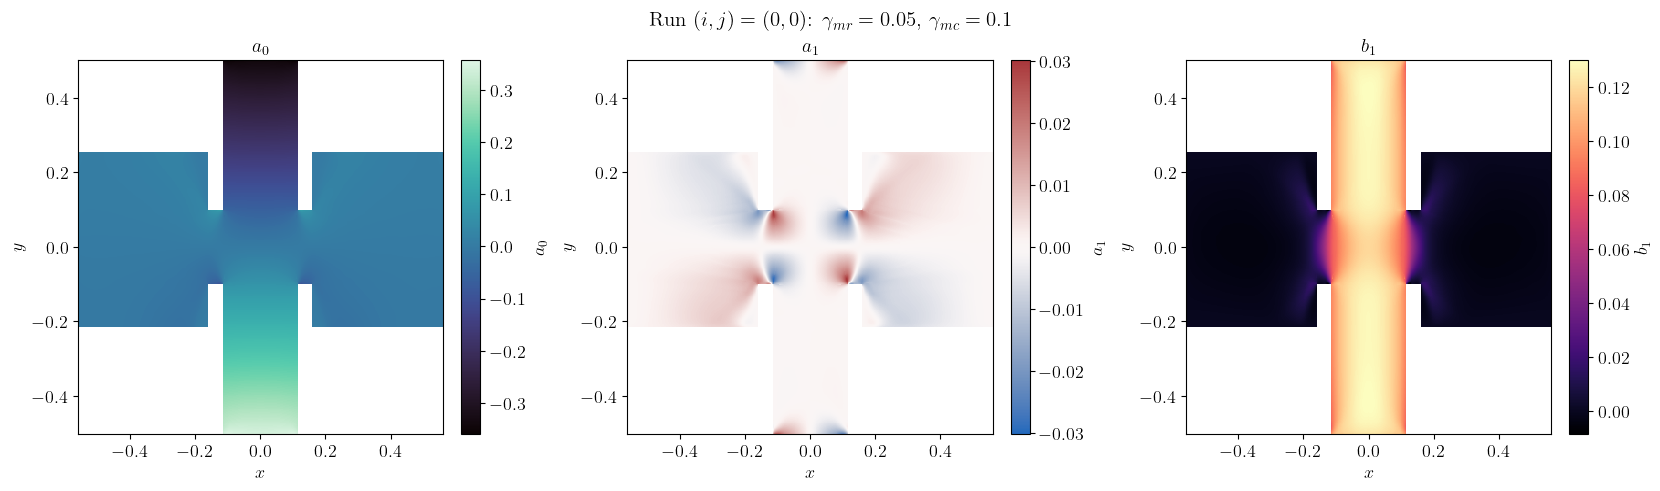

In [59]:
a0 = np.asarray(data["a0"], dtype=float)
a1 = np.asarray(data["a1"], dtype=float)
b1 = np.asarray(data["b1"], dtype=float)
x = np.asarray(data["x"], dtype=float)
y = np.asarray(data["y"], dtype=float)

cmap_a0 = sns.color_palette("mako", as_cmap=True)
cmap_div = sns.color_palette("vlag", as_cmap=True)
cmap_b1 = sns.color_palette("magma", as_cmap=True)

a1_max = np.nanmax(np.abs(a1))
b1_max = np.nanmax(np.abs(b1))

X, Y = np.meshgrid(x, y, indexing="ij")

fig, axes = plt.subplots(1, 3, figsize=(16.5, 4.8), constrained_layout=True)

m0 = axes[0].pcolormesh(X, Y, a0, cmap=cmap_a0, shading="auto")
axes[0].set_title(r"$a_0$")
axes[0].set_xlabel(r"$x$")
axes[0].set_ylabel(r"$y$")
fig.colorbar(m0, ax=axes[0], label=r"$a_0$")

m1 = axes[1].pcolormesh(X, Y, a1, cmap=cmap_div, vmin=-a1_max, vmax=a1_max, shading="auto")
axes[1].set_title(r"$a_1$")
axes[1].set_xlabel(r"$x$")
axes[1].set_ylabel(r"$y$")
fig.colorbar(m1, ax=axes[1], label=r"$a_1$")

m2 = axes[2].pcolormesh(X, Y, b1, cmap=cmap_b1, shading="auto")
axes[2].set_title(r"$b_1$")
axes[2].set_xlabel(r"$x$")
axes[2].set_ylabel(r"$y$")
fig.colorbar(m2, ax=axes[2], label=r"$b_1$")

fig.suptitle(
    rf"Run $(i,j)=({I_IDX},{J_IDX})$: $\gamma_{{mr}}={gamma_mr:.3g}$, $\gamma_{{mc}}={gamma_mc:.3g}$",
    fontsize=15,
)
plt.show()


## Figure 2: Normalized strip profiles of $b_1(x)$

At fixed `I_IDX` (fixed `gamma_mr`), choose evenly spaced `J_IDX` values across `gamma_mc`.
For each run, at fixed `y = Y_CUT`, take `b1[:, y_index]`, compute
$I_y(y_*) = \int b_1(x, y_*)\,dx$, and plot $b_1(x, y_*) / I_y(y_*)$.


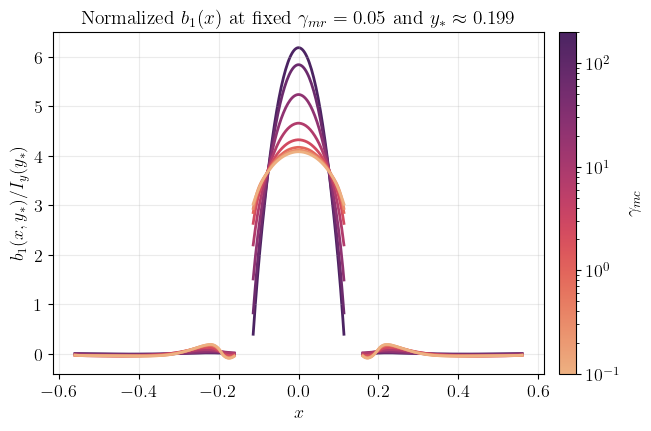

In [65]:
# Cut configuration for this figure
Y_CUT = 0.20
N_GAMMA_MC_CURVES = 8

i_index = I_IDX
if i_index >= len(gamma_mr_vals):
    raise IndexError(f"I_IDX={i_index} out of bounds for gamma_mr grid of size {len(gamma_mr_vals)}")

j_available = sorted(j for (i, j) in by_ij.keys() if i == i_index)
if len(j_available) == 0:
    raise RuntimeError(f"No runs found for i={i_index}")

n_pick = min(N_GAMMA_MC_CURVES, len(j_available))
pick_positions = np.linspace(0, len(j_available) - 1, n_pick).round().astype(int)
j_picks = [j_available[k] for k in pick_positions]

y_ref = np.asarray(data["y"], dtype=float)
y_index = int(np.argmin(np.abs(y_ref - Y_CUT)))
y_used = float(y_ref[y_index])

gamma_mc_sel = np.array([by_ij[(i_index, j)][0]["gamma_mc"] for j in j_picks], dtype=float)
gamma_pos = gamma_mc_sel[gamma_mc_sel > 0]
if gamma_pos.size == 0:
    raise RuntimeError("All selected gamma_mc values are nonpositive; log color scale is undefined.")
gamma_min = float(np.min(gamma_pos))
gamma_max = float(np.max(gamma_pos))
if np.isclose(gamma_min, gamma_max):
    gamma_max = gamma_min * 10.0

cmap_line = sns.color_palette("flare", as_cmap=True)
norm = plt.matplotlib.colors.LogNorm(vmin=gamma_min, vmax=gamma_max)

fig, ax = plt.subplots(figsize=(6.4, 4.2), constrained_layout=True)
plotted = 0

for j in j_picks:
    params_j, path_j = by_ij[(i_index, j)]
    d = load_observables(path_j)

    x = np.asarray(d["x"], dtype=float)
    b1 = np.asarray(d["b1"], dtype=float)

    # b1 is interpreted as [x, y], so fixed-y cut along x is b1[:, y_index]
    b1_x = b1[:, y_index]

    # Keep NaNs in the plotted array so line segments break across holes in the domain.
    finite_x = np.isfinite(x)
    if np.count_nonzero(finite_x) < 2:
        continue

    x_line = x[finite_x]
    b1_line = b1_x[finite_x]

    # Normalize using only finite samples of b1; plotting still preserves NaN gaps.
    finite_b1 = np.isfinite(b1_line)
    if np.count_nonzero(finite_b1) < 2:
        continue

    I_y = float(np.trapezoid(b1_line[finite_b1], x_line[finite_b1]))
    if np.isclose(I_y, 0.0):
        continue

    gamma_mc = float(params_j["gamma_mc"])
    if gamma_mc <= 0:
        continue

    y_plot = b1_line / I_y

    # Reverse layering: smaller gamma_mc are drawn on top.
    z = norm(gamma_mc)
    ax.plot(x_line, y_plot, lw=2.0, color=cmap_line(norm(gamma_mc)), zorder=10.0 - 9.0 * z)
    plotted += 1

if plotted == 0:
    raise RuntimeError("No valid line cuts plotted. Try a different Y_CUT or check data quality for this i-index.")

sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap_line)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label(r"$\gamma_{mc}$")

ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$b_1(x, y_*) / I_y(y_*)$")
ax.set_title(rf"Normalized $b_1(x)$ at fixed $\gamma_{{mr}}={gamma_mr_vals[i_index]:.3g}$ and $y_*\approx {y_used:.3g}$")
ax.grid(True, alpha=0.25)
plt.show()
